In [129]:
import numpy as np
import scipy as sp
import scipy.sparse
import scipy.sparse.linalg
from scipy.sparse import csc_matrix
from scipy.sparse import lil_matrix

In [168]:
import matplotlib.pyplot as plt
#%matplotlib inline

In [132]:
from numba import autojit

#@autojit
def func(arr, v0, p0, q0, A, B):
    
    N = len(arr)/3
    p = arr[:N]
    q = arr[N: 2*N]
    v = arr[2*N:]
    h = 1e-4
    
    F1 = np.zeros(N)
    F2 = np.zeros(N)
    F3 = np.zeros(N)
    
    F1[0] = p[0] - p0 + h*(-1. - (p0**2 + q0**2) / v0**2) 
    F2[0] = q[0] - q0 + h*(A - B*(p0**2 + q0**2) / v0**2)
    F3[0] = v[0]**2 - v0**2 - 2*h*(p0 + B*q0) 
    for i in xrange(1, N):
        F1[i] = p[i] - p[i-1] + h*(-1. - (p[i-1]**2 + q[i-1]**2) / v[i-1]**2)  
        F2[i] = q[i] - q[i-1] + h*(A - B*(p[i-1]**2 + q[i-1]**2) / v[i-1]**2) 
        F3[i] = v[i]**2 - v[i-1]**2 - 2*h*(p[i-1] + B*q[i-1]) 
        
#     F1[N-1] = 0 - p[N-1] + h*r[N-1] * (p[N-1]**2 + q[N-1]**2) / v[N-2]**2 + h*P[N-1]  
#     F2[N-1] = 0 - q[N-1] + h*x[N-1] * (p[N-1]**2 + q[N-1]**2) / v[N-2]**2 + h*Q[N-1] 
    
#     for i in xrange(1, N):
#         F3[i] = v[i]**2 - v[i-1]**2 + 2*h*(r[i]*p[i] + x[i]*q[i]) #- (r[i]**2 + x[i]**2)*(p[i]**2 + q[i]**2) / v[i-1]**2)
#     F3[0] = v[0]**2 - v0**2 + 2*h*(r[0]*p[0] + x[0]*q[0])  #+ (r[0]**2 + x[0]**2)*(p[0]**2 + q[0]**2) / v0**2) 
    
    return np.concatenate((F1, F2, F3), axis=0)


def jacob(arr, v0, p0, q0, A, B):
   
    N= len(arr)/3
    J = lil_matrix((3*N, 3*N))
    p = arr[:N]
    q = arr[N: 2*N]
    v = arr[2*N:]
    h = 1e-4
    
    J[0,0] = 1.
    J[N,N] = 1.
    J[2*N, 2*N] = 2*v[0]
    
    for i in xrange (1,N):
        J[i, i-1] = -1. - 2*h*p[i-1] / v[i-1]**2
        J[i, i] = 1.
        J[i, i+N-1] = -2*h*q[i-1] / v[i-1]**2
        J[i, i+2*N-1] = 2*h*(p[i-1]**2 + q[i-1]**2) / v[i-1]**3
        
        J[i+N, i-1] = -2*h*B*p[i-1] / v[i-1]**2
        J[i+N, i+N] = 1.
        J[i+N, i+N-1] = -1. - 2*h*B*q[i-1] / v[i-1]**2
        J[i+N, i+2*N-1] = 2*h*B*(p[i-1]**2 + q[i-1]**2) / v[i-1]**3
        
        J[i+2*N, i-1] = -2*h
        J[i+2*N, i+N-1] = -2*h*B
        J[i+2*N, i+2*N-1] = -2*v[i-1]
        J[i+2*N, i+2*N] = 2*v[i]
        
    J = csc_matrix(J)   
    return J
    

In [144]:
import scipy as sp
import scipy.optimize

N = 5000
v0 = 1.
p0 = 0.
q0 = 0.
A = -0.5
r = 1.
x = 1.
B = r/x
arr0 = np.ones(3*N)

# x = np.ones(N)
# r = np.ones(N)
# P = np.zeros(N)
# Q = np.zeros(N)
# P[:] = 1.
# Q[:] = 0.5

#rhs = func(arr0, x, r, P, Q, v0)
def func_newton(arr): return func(arr, v0, p0, q0, A, B) 
def jacob_newton(arr): return jacob(arr, v0, p0, q0, A, B)
def newton(x, tolF, toldx, maxiters):
    
    for i in xrange(maxiters):
        F = func_newton(x)
        J = jacob_newton(x)
        dx = sp.sparse.linalg.spsolve(J, -F)
        normF = np.linalg.norm(F)
        normdx = np.linalg.norm(dx)
        x = x + dx
        if normF < tolF and normdx < toldx:         
            print 'Converged to x=', x,' in', i, 'iterations'
            return x
       
        if iter == maxiters:    
            print 'Non-Convergence after', i,' iterations!!!'
            return x
        
sol = newton(arr0,1e-3, 1e-3, 50)        
#sol = sp.optimize.broyden1(func_newton, arr0, f_tol = 10e-3)

Converged to x= [  1.00000000e-04   2.00000001e-04   3.00000006e-04 ...,   1.18296445e+00
   1.18303602e+00   1.18310761e+00]  in 5 iterations


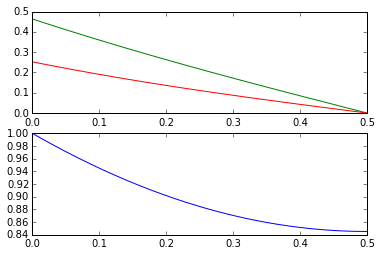

In [179]:
s = np.linspace(0.0001,0.5,5000)
z = 0.5 - s
f, (ax1,ax2) = plt.subplots(2, 1)
ax1.plot(z, sol[:N]/sol[3*N-1], 'g')
ax1.plot(z, sol[N:2*N]/sol[3*N-1], 'r')
ax2.plot(z, sol[2*N:]/sol[3*N-1])
#plt.axis([0, 5000, 0.9, 1.1])
#plt.show()